In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import warnings, gc
import feather
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

warnings.filterwarnings("ignore")
train_data = pd.read_feather('../input/amexfeather/train_data.ftr')
test_data = pd.read_feather('../input/amexfeather/test_data.ftr')

## Data Overview

The target binary variable is calculated by observing **18 months performance window** after the latest credit card statement, and if the customer does not pay due amount in **120 days** after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:
<br>
D_* : Delinquency variables
<br>
S_* : Spend variables
<br>
P_* : Payment variables
<br>
B_* : Balance variables
<br>
R_* : Risk variables
<br>
With the following features being categorical: B_30, B_38, D_63, D_64, D_66, D_68, D_114, D_116, D_117, D_120, D_126.

There are a total of 190 variables in the dataset with approximately 450,000 customers in the training set and 925,000 in the test set.

In [30]:
train = train_data.groupby('customer_ID').tail(1).set_index('customer_ID')
print("The training data begins on {} and ends on {}.".format(train['S_2'].min().strftime('%m-%d-%Y'),train['S_2'].max().strftime('%m-%d-%Y')))
print("There are {:,.0f} customers in the training set and {} features.".format(train.shape[0],train.shape[1]))


test = test_data.groupby('customer_ID').tail(1).set_index('customer_ID')
print("\nThe test data begins on {} and ends on {}.".format(test['S_2'].min().strftime('%m-%d-%Y'),test['S_2'].max().strftime('%m-%d-%Y')))
print("There are {:,.0f} customers in the test set and {} features.".format(test.shape[0],test.shape[1]))

del test['S_2']
gc.collect()

The training data begins on 03-01-2018 and ends on 03-31-2018.
There are 458,913 customers in the training set and 190 features.

The test data begins on 04-01-2019 and ends on 10-31-2019.
There are 924,621 customers in the test set and 189 features.


762

In [5]:
train_data

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979492,0.416016,0.020813,0.828125,0.003487,0.090759,0.005341,0.025146,...,NaN,NaN,0.006836,0.003679,0.000457,NaN,0.000906,0.001497,0.002775,0
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984863,0.296631,0.007210,0.812500,0.005905,0.079895,0.002243,0.023697,...,NaN,NaN,0.003309,0.007095,0.007858,NaN,0.002777,0.008224,0.008858,0
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.982910,0.444092,0.013153,0.815430,0.003456,0.100525,0.002111,0.012344,...,NaN,NaN,0.009956,0.009995,0.001088,NaN,0.005692,0.006775,0.005566,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969727,0.442627,0.009857,1.003906,0.005116,0.101807,0.009933,0.008575,...,NaN,NaN,0.005543,0.006565,0.009880,NaN,0.008125,0.001168,0.003983,0


In [7]:
print(train_data.info())

print(train_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: category(11), datetime64[ns](1), float16(177), int64(1), object(1)
memory usage: 2.0+ GB
None
                P_2          D_39           B_1           B_2           R_1  \
count  5.485466e+06  5.531451e+06  5.531451e+06  5.529435e+06  5.531451e+06   
mean            NaN           NaN           NaN           NaN           NaN   
std    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
min   -4.589844e-01  0.000000e+00 -7.589844e+00  0.000000e+00  0.000000e+00   
25%    4.802246e-01  4.528046e-03  8.865356e-03  1.053467e-01  2.895355e-03   
50%    6.943359e-01  9.056091e-03  3.134155e-02  8.144531e-01  5.783081e-03   
75%    8.647461e-01  2.366943e-01  1.258545e-01  1.001953e+00  8.659363e-03   
max    1.009766e+00  5.390625e+00  1.324219e+00  1.009766e+00  3.255859e+00   

                S_3          D_41           B_3           D_42

In [8]:
train_data.select_dtypes(['category'])

,D_63,D_64,D_66,D_68,B_30,B_38,D_114,D_116,D_117,D_120,D_126
0,CR,O,NaN,6.0,0.0,2.0,1.0,0.0,4.0,0.0,1.0
1,CR,O,NaN,6.0,0.0,2.0,1.0,0.0,4.0,0.0,1.0
2,CR,O,NaN,6.0,0.0,2.0,1.0,0.0,4.0,0.0,1.0
3,CR,O,NaN,6.0,0.0,2.0,1.0,0.0,4.0,0.0,1.0
4,CR,O,NaN,6.0,0.0,2.0,1.0,0.0,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5531446,CL,O,NaN,5.0,0.0,3.0,1.0,0.0,3.0,0.0,1.0
5531447,CL,O,NaN,5.0,0.0,3.0,1.0,0.0,3.0,0.0,1.0
5531448,CL,O,NaN,5.0,0.0,3.0,1.0,0.0,3.0,0.0,1.0
5531449,CL,O,NaN,5.0,0.0,3.0,1.0,0.0,3.0,0.0,1.0


In [34]:
train_data.select_dtypes(['datetime64']).describe()

,S_2
count,5531451
unique,396
top,2018-02-17 00:00:00
freq,26715
first,2017-03-01 00:00:00
last,2018-03-31 00:00:00


## Exploratory Data Analysis

In [78]:
# train.columns = train_data.columns[1:]
# print(train.columns)
# train_data.columns
# train['Spend 2']

In [73]:
# Rename Columns
# train.columns = train.columns.str.replace('S_2', 'Date')
titles=['Delinquency '+str(i).split('_')[1] if i.startswith('D') else 'Spend '+str(i).split('_')[1] 
        if i.startswith('S') else 'Payment '+str(i).split('_')[1]  if i.startswith('P') 
        else 'Balance '+str(i).split('_')[1] if i.startswith('B') else 
        'Risk '+str(i).split('_')[1] for i in train.columns[:-1]]
cat_cols=['Balance 30', 'Balance 38', 'Delinquency 63', 'Delinquency 64', 'Delinquency 66', 'Delinquency 68',
          'Delinquency 114', 'Delinquency 116', 'Delinquency 117', 'Delinquency 120', 'Delinquency 126', 'Target']
test.columns=titles[1:]
titles.append('Target')
train.columns=titles
train.rename(columns = {'Spend 2':'Date'}, inplace = True)

# Target Value
target = train.Target.value_counts(normalize=True)
target.rename(index={1:'Default',0:'Paid'},inplace=True)

In [55]:
# Target Distribution

temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), height=500, width=1000))

pal, color = ['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']
fig = go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45, 
                     showlegend=True,sort=False, 
                     marker=dict(colors=color,line=dict(color=pal,width=2.5)),
                     hovertemplate = "%{label} Accounts: %{value:.2f}%<extra></extra>"))
fig.update_layout(template=temp, title='Target Distribution', 
                  legend=dict(traceorder='reversed',y=1.05,x=0),
                  uniformtext_minsize=15, uniformtext_mode='hide',width=700)
fig.show()

In [57]:
# I see a Seasonal Trend!
plot_df=train.reset_index().groupby('Date')['customer_ID'].nunique().reset_index()

fig=go.Figure()
fig.add_trace(go.Scatter(x=plot_df['Date'], 
                         y=plot_df['customer_ID'], mode='lines',
                         line=dict(color=pal[0], width=3), 
                         hovertemplate = ''))
fig.update_layout(template=temp, title="Frequency of Customer Statements", 
                  hovermode="x unified", width=800,height=500,
                  xaxis_title='Statement Date', yaxis_title='Number of Statements Issued')
fig.show()
# del train['Date']

##### EDA of Delinqency Variables

Kernel Density Estimate Plot:
 visualizing the Probability Density of a continuous variable.

In [82]:
train[cols].describe()

,Delinquency 39,Delinquency 41,Delinquency 42,Delinquency 43,Delinquency 44,Delinquency 45,Delinquency 46,Delinquency 47,Delinquency 48,Delinquency 49,...,Delinquency 137,Delinquency 138,Delinquency 139,Delinquency 140,Delinquency 141,Delinquency 142,Delinquency 143,Delinquency 144,Delinquency 145,Target
count,4.589130e+05,4.588820e+05,59910.000000,324591.000000,436618.000000,458882.000000,363790.000000,458913.000000,400921.000000,51763.000000,...,1.639500e+04,1.639500e+04,456083.000000,458913.000000,4.560830e+05,80315.000000,456083.000000,458913.000000,456083.000000,458913.000000
mean,NaN,0.000000e+00,0.177979,0.000000,0.000000,NaN,NaN,NaN,NaN,0.191162,...,1.412201e-02,1.589355e-01,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.258934
std,0.000000e+00,0.000000e+00,0.253662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.278320,...,9.527588e-02,2.609863e-01,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.438050
min,5.960464e-08,5.960464e-08,-0.000240,0.000002,0.000000,0.000003,-4.433594,-0.026611,-0.009605,0.000009,...,3.576279e-07,1.788139e-07,0.000000,0.000000,1.192093e-07,-0.011436,0.000000,0.000000,0.000000,0.000000
25%,4.783630e-03,3.007889e-03,0.031769,0.043335,0.003994,0.054749,0.425049,0.227661,0.084106,0.059998,...,2.519608e-03,3.482819e-03,0.003046,0.002552,3.026962e-03,0.200684,0.003033,0.002758,0.003031,0.000000
50%,9.559631e-03,6.011963e-03,0.108276,0.092407,0.008034,0.147705,0.460693,0.369873,0.317139,0.129272,...,5.050659e-03,7.026672e-03,0.006077,0.005119,6.050110e-03,0.385986,0.006065,0.005501,0.006073,0.000000
75%,2.666016e-01,8.995056e-03,0.230347,0.195068,0.134155,0.361572,0.521484,0.550781,0.734375,0.246704,...,7.579803e-03,5.014648e-01,0.009102,0.007675,9.101868e-03,0.573730,0.009094,0.008255,0.009102,1.000000
max,5.000000e+00,8.992188e+00,4.187500,9.187500,4.003906,1.610352,12.531250,1.383789,8.960938,27.500000,...,1.009766e+00,2.505859e+00,1.009766,1.009766,1.339844e+00,2.228516,1.009766,1.343750,4.828125,1.000000


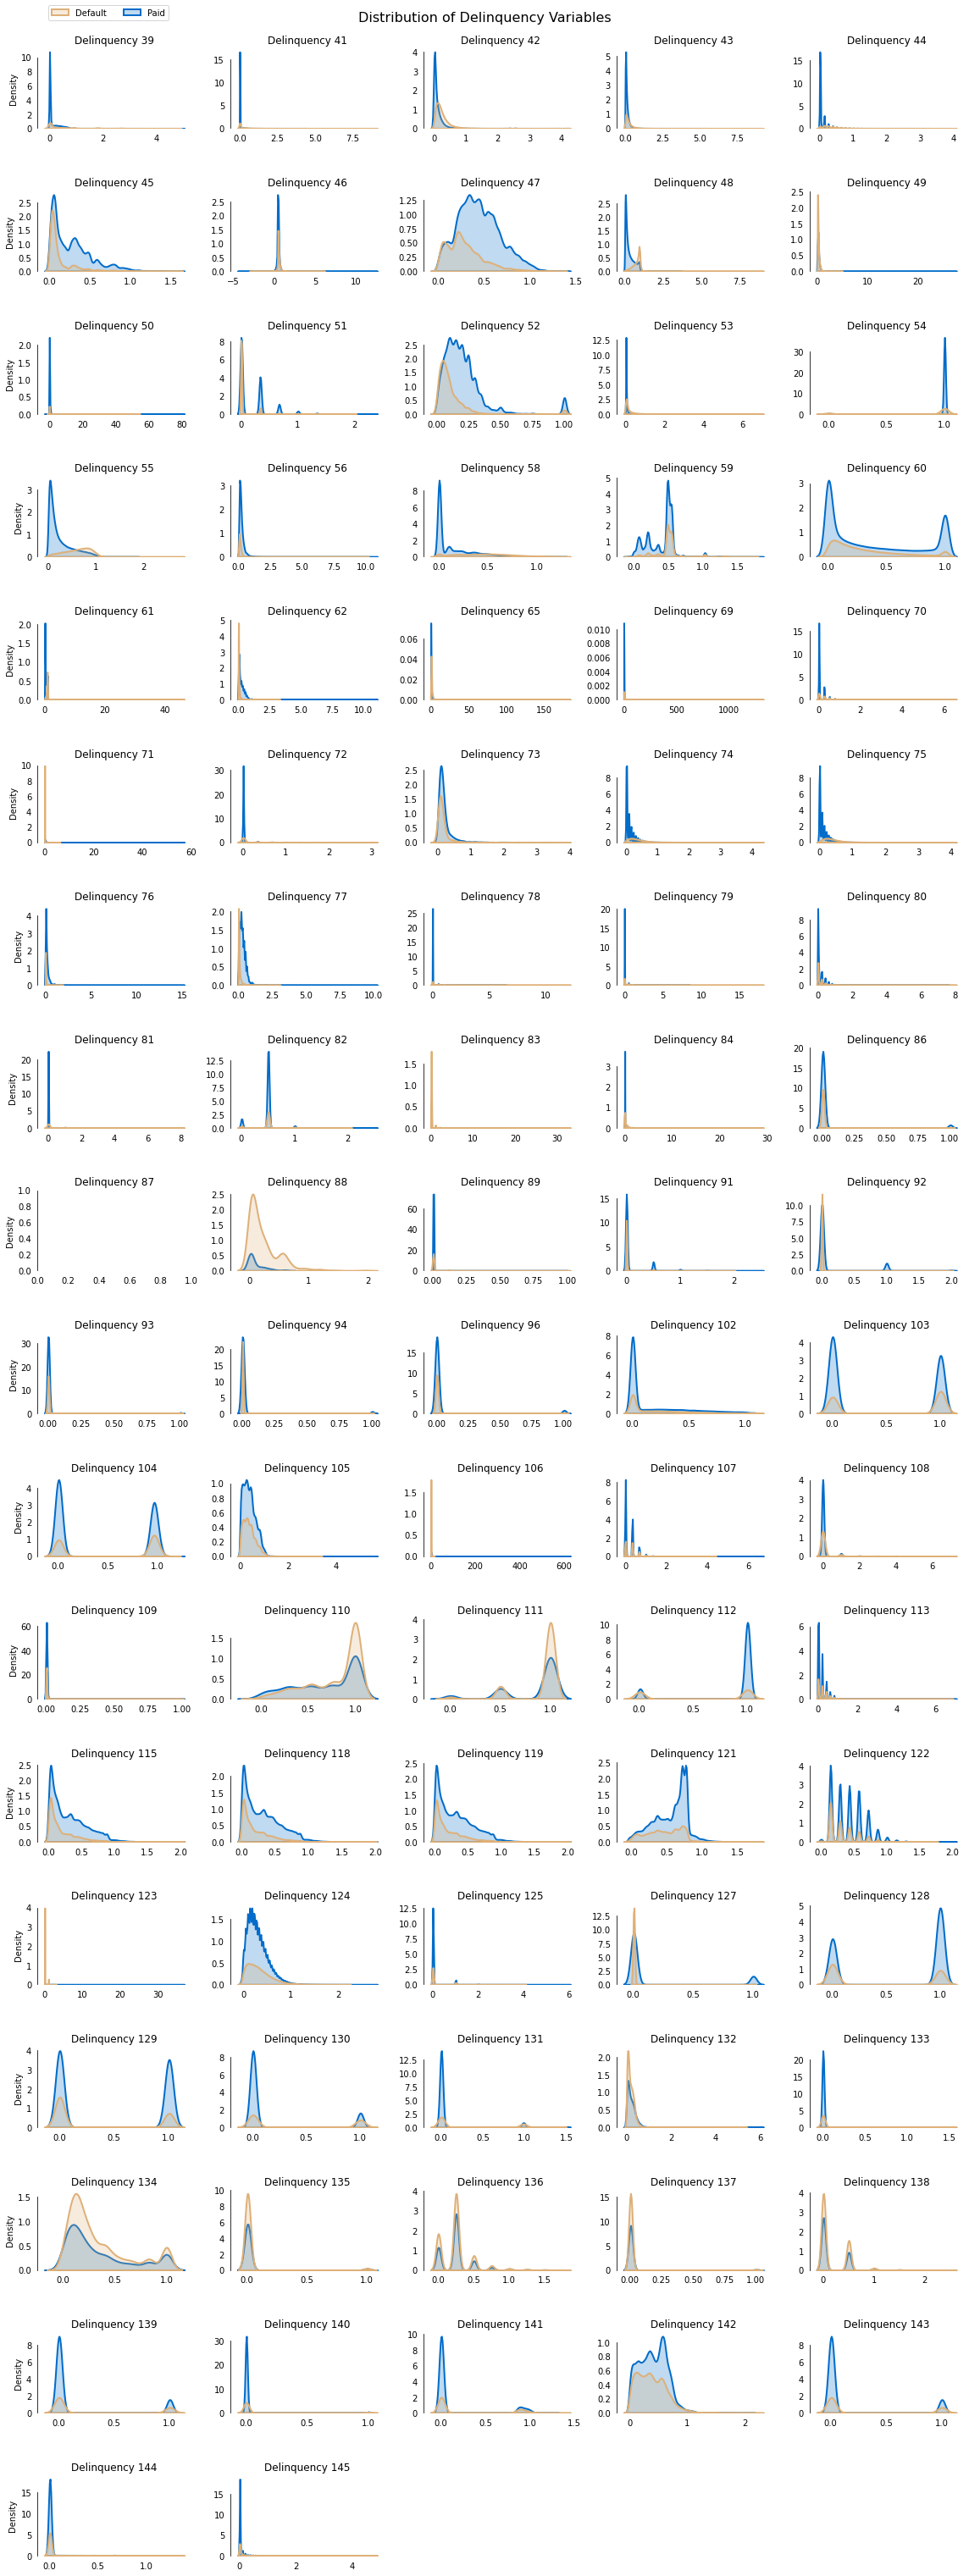

In [79]:
cols=[col for col in train.columns if (col.startswith(('D','T'))) & (col not in cat_cols[:-1])]
cols.remove('Date')
plot_df=train[cols]
fig, ax = plt.subplots(18,5, figsize=(16,54))
fig.suptitle('Distribution of Delinquency Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*18

for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='Target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
    
for i in range(2,5):
    ax[17,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.983))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

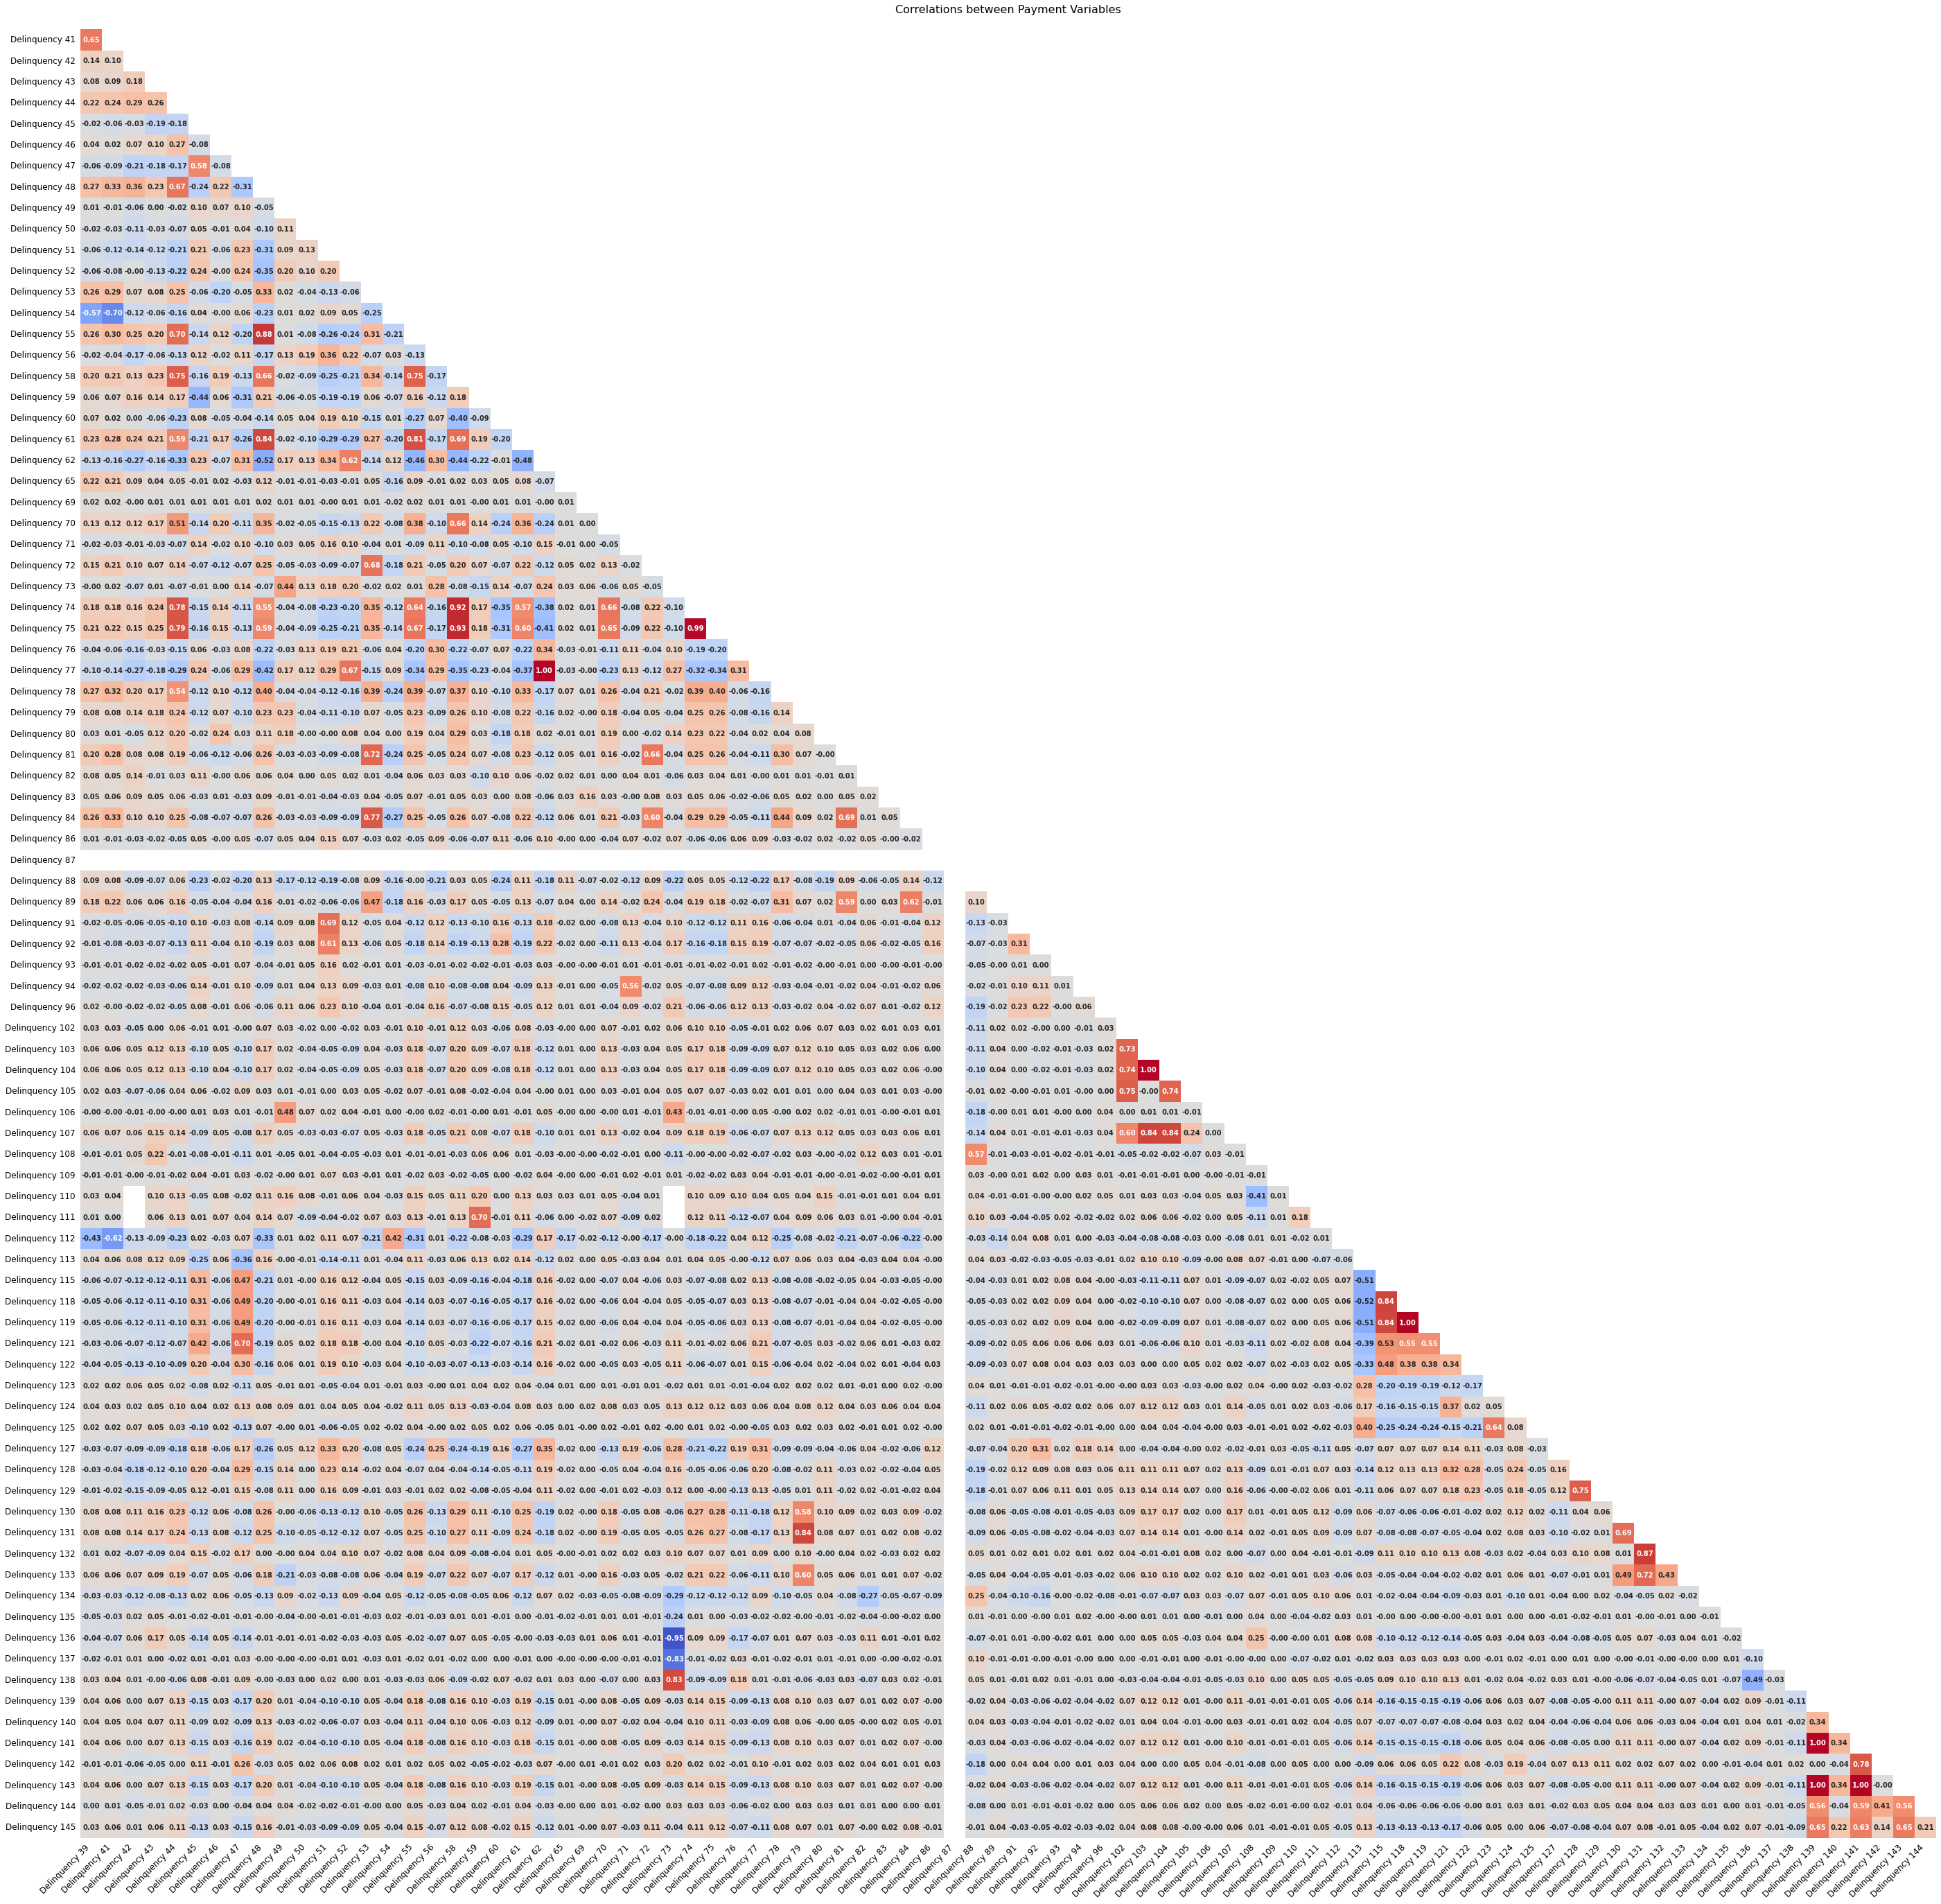

In [83]:
corr=plot_df.iloc[:,:-1].corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(48,48))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Payment Variables\n', fontsize=16)
fig.show()

<!-- There are several highly correlated Delinquency variables, with a few pairs perfectly positively correlated at 1.0. There are also a number of missing correlations, particularly in Delinquency 87, due to null values in the data. -->

Some of the highly corrolated ones: 

In [89]:
# print( plot_df[['Delinquency 74','Delinquency 75']].corr().iloc[1,0] )
# print( plot_df[['Delinquency 58','Delinquency 74']].corr().iloc[1,0] )
# print( plot_df[['Delinquency 113','Delinquency 115']].corr().iloc[1,0] )
# print( plot_df[['Delinquency 131','Delinquency 132']].corr().iloc[1,0] )

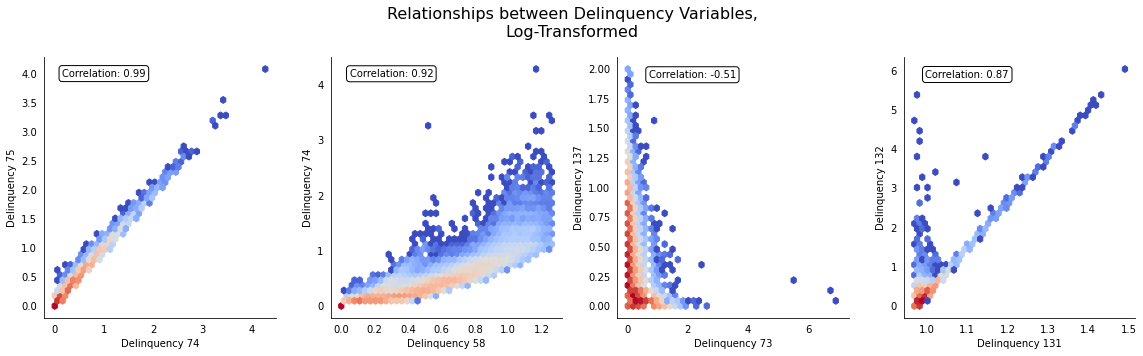

In [86]:
fig, ax = plt.subplots(1,4, figsize=(16,5))
fig.suptitle('Relationships between Delinquency Variables,\nLog-Transformed',fontsize=16)
ax[0].hexbin(x='Delinquency 74', y='Delinquency 75', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0].set(xlabel='Delinquency 74',ylabel='Delinquency 75')
ax[0].text(1, 4, 'Correlation: {:.2f}'.format(plot_df[['Delinquency 74','Delinquency 75']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))

ax[1].hexbin(x='Delinquency 58', y='Delinquency 74', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1].set(xlabel='Delinquency 58',ylabel='Delinquency 74')
ax[1].text(0.3, 4.2, 'Correlation: {:.2f}'.format(plot_df[['Delinquency 58','Delinquency 74']].corr().iloc[1,0]),
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))

ax[2].hexbin(x='Delinquency 113', y='Delinquency 115', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[2].set(xlabel='Delinquency 73',ylabel='Delinquency 137')
ax[2].text(2.15, 1.95, 'Correlation: {:.2f}'.format(plot_df[['Delinquency 113','Delinquency 115']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))

ax[3].hexbin(x='Delinquency 131', y='Delinquency 132', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[3].set(xlabel='Delinquency 131',ylabel='Delinquency 132')
ax[3].text(1.1, 5.9, 'Correlation: {:.2f}'.format(plot_df[['Delinquency 131','Delinquency 132']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
           
for i in range(4):
    ax[i].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

EDA of Spend Variables

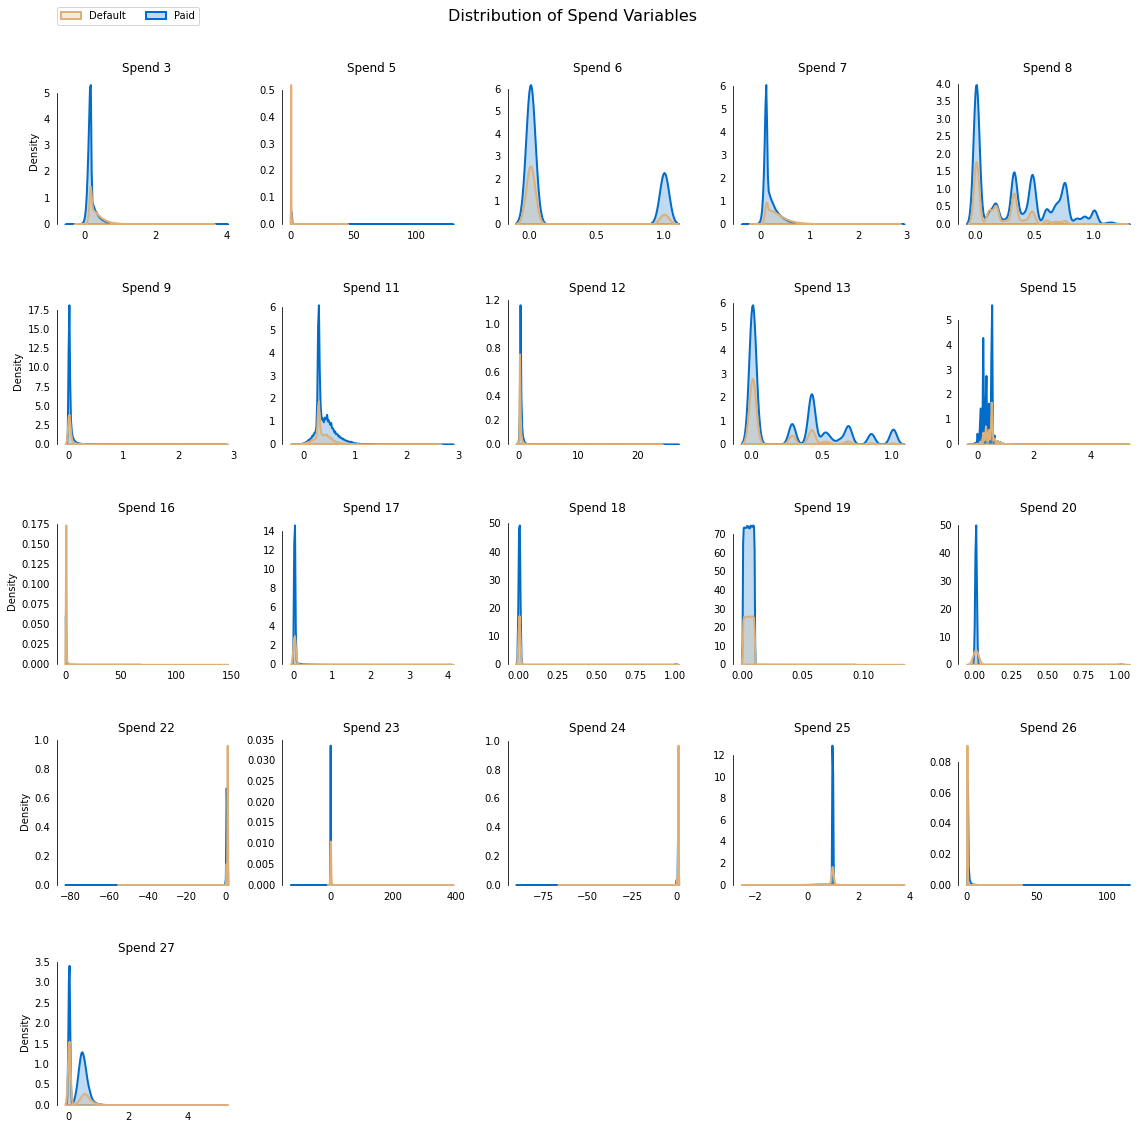

In [91]:
cols=[col for col in train.columns if (col.startswith(('S','T'))) & (col not in cat_cols[:-1])]


plot_df=train[cols]
fig, ax = plt.subplots(5,5, figsize=(16,20))
fig.suptitle('Distribution of Spend Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*5
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='Target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(1,5):
    ax[4,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.985))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

In [95]:
corr=plot_df.corr()
# mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
# corr= corr.iloc[1:,:-1].copy()
corr

,Spend 3,Spend 5,Spend 6,Spend 7,Spend 8,Spend 9,Spend 11,Spend 12,Spend 13,Spend 15,...,Spend 18,Spend 19,Spend 20,Spend 22,Spend 23,Spend 24,Spend 25,Spend 26,Spend 27,Target
Spend 3,1.000000,0.048081,0.015653,0.909011,-0.394377,0.039617,-0.155890,0.017312,-0.202898,0.458619,...,0.009796,0.017230,0.211830,0.016295,0.062927,0.014317,-0.088299,-0.064144,0.069920,0.340999
Spend 5,0.048081,1.000000,-0.093840,0.061499,0.090422,0.042670,0.045614,0.039005,0.158305,-0.033640,...,0.047150,-0.000179,0.025993,0.047629,0.018736,0.052653,-0.000407,0.076437,0.071539,0.042203
Spend 6,0.015653,-0.093840,1.000000,-0.010589,-0.431530,0.045862,-0.236338,-0.062627,-0.350636,0.270418,...,-0.025945,0.000494,-0.041875,-0.279522,-0.018430,-0.315003,0.111164,-0.069086,0.026652,-0.127649
Spend 7,0.909011,0.061499,-0.010589,1.000000,-0.347084,0.033919,-0.124107,0.037097,-0.142849,0.406058,...,0.008091,0.015316,0.203271,0.028883,0.067129,0.027458,-0.077818,-0.055602,0.103075,0.347408
Spend 8,-0.394377,0.090422,-0.431530,-0.347084,1.000000,-0.024866,0.391609,0.142963,0.702917,-0.776161,...,0.033652,0.002101,-0.022189,0.217796,-0.024996,0.246859,0.097805,0.127704,0.205661,-0.193305
Spend 9,0.039617,0.042670,0.045862,0.033919,-0.024866,1.000000,-0.025380,-0.000736,0.024365,0.033064,...,0.018661,0.001723,0.012678,0.005314,0.006275,0.004392,-0.003812,0.004146,0.072668,0.062576
Spend 11,-0.155890,0.045614,-0.236338,-0.124107,0.391609,-0.025380,1.000000,0.090695,0.494514,-0.328024,...,0.033440,0.001568,-0.014476,0.105597,0.008713,0.120572,0.054594,0.138867,0.015584,-0.085733
Spend 12,0.017312,0.039005,-0.062627,0.037097,0.142963,-0.000736,0.090695,1.000000,0.217963,-0.062123,...,0.011391,0.001465,0.005851,0.049592,-0.001346,0.055152,0.013739,0.038931,0.085658,-0.002455
Spend 13,-0.202898,0.158305,-0.350636,-0.142849,0.702917,0.024365,0.494514,0.217963,1.000000,-0.383117,...,0.055988,0.005028,-0.009027,0.189998,-0.017571,0.212566,0.101487,0.193273,0.353603,-0.160058
Spend 15,0.458619,-0.033640,0.270418,0.406058,-0.776161,0.033064,-0.328024,-0.062123,-0.383117,1.000000,...,-0.019034,-0.000970,0.042055,-0.128777,0.029715,-0.148993,-0.083247,-0.078972,-0.052876,0.209855


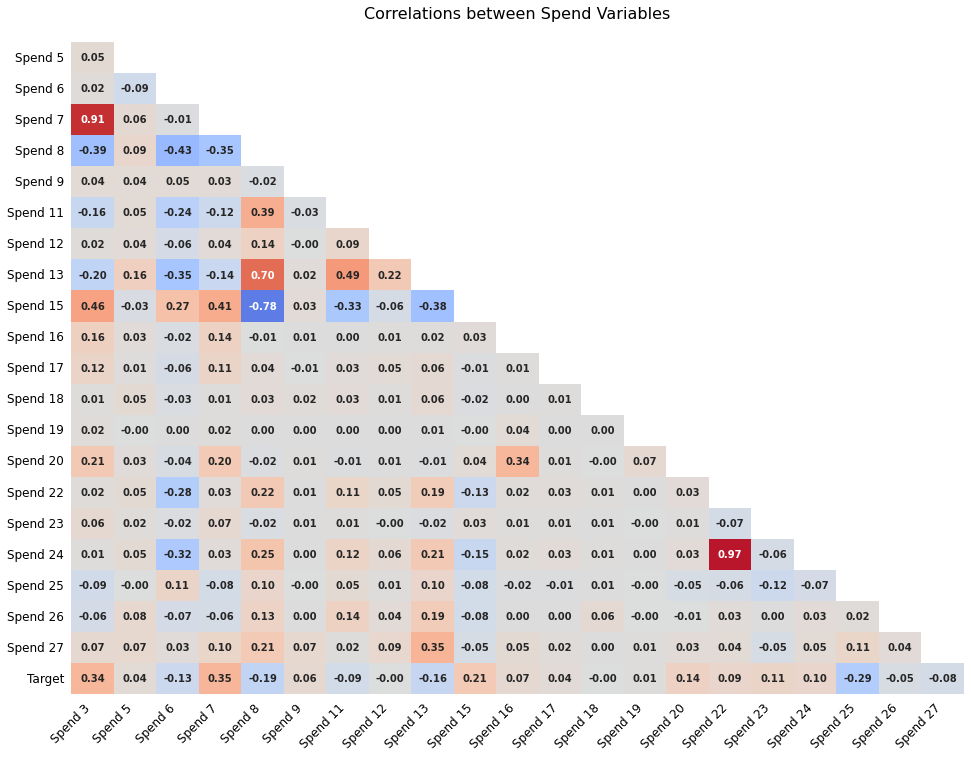

In [92]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(16,12))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Spend Variables\n', fontsize=16)
fig.show()